# Gaussian Naive Bayesian alogorithm

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
# 모델저장
from joblib import dump, load

In [2]:
from IPython.display import Image
width=700; height=500

## Likelihood

(array([  2.,  22.,  69., 141., 226., 263., 177.,  78.,  17.,   5.]),
 array([-1.35919768, -0.68874583, -0.01829399,  0.65215785,  1.32260969,
         1.99306153,  2.66351338,  3.33396522,  4.00441706,  4.6748689 ,
         5.34532074]),
 <BarContainer object of 10 artists>)

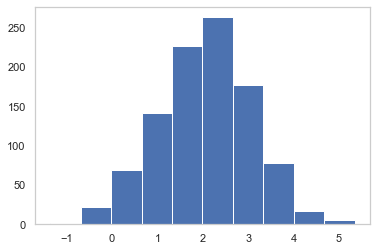

In [7]:
sns.set_style("whitegrid", {'axes.grid' : False})
mu_A, sigma_A = 2, 1; mu_B, sigma_B = 4, 2
plt.hist(np.random.normal(mu_A, sigma_A, size=(1000)))

(array([  4.,  21.,  83., 157., 247., 229., 160.,  72.,  22.,   5.]),
 array([-2.23847965, -0.99866651,  0.24114663,  1.48095978,  2.72077292,
         3.96058606,  5.2003992 ,  6.44021235,  7.68002549,  8.91983863,
        10.15965178]),
 <BarContainer object of 10 artists>)

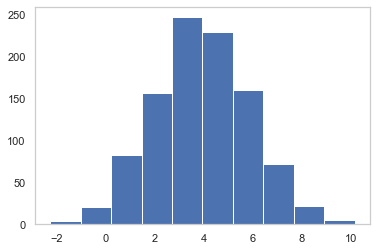

In [8]:
plt.hist(np.random.normal(mu_B, sigma_B, size=(1000)))

### 1. probability density function이 우도(likelihood)

In [4]:
import scipy
scipy.stats.norm(mu_A, sigma_A).pdf(2) # '2'를 관측하였을 경우 A분포의 우도
scipy.stats.norm(mu_B, sigma_B).pdf(2) # '2'를 관측하였을 경우 B분포의 우도

0.3989422804014327

0.12098536225957168

In [5]:
import scipy.stats
scipy.stats.norm(mu_A, sigma_A).pdf(2)*scipy.stats.norm(mu_A, sigma_A).pdf(2.5)*scipy.stats.norm(mu_A, sigma_A).pdf(3)

0.03398569427202652

In [6]:
scipy.stats.norm(mu_B, sigma_B).pdf(2)*scipy.stats.norm(mu_B, sigma_B).pdf(2.5)*scipy.stats.norm(mu_B, sigma_B).pdf(3)

0.0032067184922020733

### 2. MAP (Maximum A posterio)
https://en.wikipedia.org/wiki/Naive_Bayes_classifier

In [9]:
df = pd.DataFrame({'성별' : ['남성', '남성', '남성', '남성','여성','여성','여성','여성'],
                  '신장' : [6, 5.92, 5.58, 5.92, 5, 5.5, 5.42, 5.75], # feet
                  '무게' : [180, 190, 170, 165, 100, 150, 130, 150],  # pounds
                  '발의크기' : [12, 11, 12, 10, 6, 8, 7, 9]})             # inches
data = df.groupby('성별')['신장', '무게', '발의크기'].agg(['mean','var']).reset_index('성별')
df = df.merge(data, on='성별')
df = df.append({'신장':6, '무게':130, '발의크기':8}, ignore_index=True)
df

,성별,신장,무게,발의크기,"(신장, mean)","(신장, var)","(무게, mean)","(무게, var)","(발의크기, mean)","(발의크기, var)"
0,남성,6.00,180.0,12.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
1,남성,5.92,190.0,11.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
2,남성,5.58,170.0,12.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
3,남성,5.92,165.0,10.0,5.8550,0.035033,176.25,122.916667,11.25,0.916667
4,여성,5.00,100.0,6.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
5,여성,5.50,150.0,8.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
6,여성,5.42,130.0,7.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
7,여성,5.75,150.0,9.0,5.4175,0.097225,132.50,558.333333,7.50,1.666667
8,NaN,6.00,130.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data
mu_m, sigma_m = data.iloc[0,1], np.sqrt(data.iloc[0,2]); (mu_m, sigma_m**2)
mu_f, sigma_f = data.iloc[1,1], np.sqrt(data.iloc[1,2]); (mu_f, sigma_f**2)

성별      신장                무게               발의크기          
         mean       var    mean         var   mean       var
0  남성  5.8550  0.035033  176.25  122.916667  11.25  0.916667
1  여성  5.4175  0.097225  132.50  558.333333   7.50  1.666667

(5.855, 0.0350333333333333)

(5.4175, 0.09722499999999992)

In [11]:
like_m = scipy.stats.norm(mu_m, sigma_m).pdf(6)
print('남성 우도는 {0:.3f}이고, 남성일 사후확률은 {1:.2f}'.format(like_m,0.5*like_m))
like_f = scipy.stats.norm(mu_f, sigma_f).pdf(6)
print('여성 우도는 {0:.3f}이고, 여성일 사후확률은 {1:.2f}'.format(like_f,0.5*like_f))

남성 우도는 1.579이고, 남성일 사후확률은 0.79
여성 우도는 0.223이고, 여성일 사후확률은 0.11


Text(6.0, 1.5788831832641042, '     Likelihood of 6 feet')

Text(0.5, 1.0, '키가 6피트인 사람이 남성일 가능성(Likelihood)')

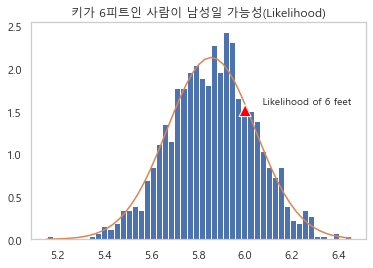

In [12]:
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
s = np.random.normal(mu_m, sigma_m, 1000)
fig, ax = plt.subplots()
n, bins, ignored = ax.hist(s, 50, density=1) # 50 bins
ax.annotate('     Likelihood of 6 feet', xy=(6., like_m), arrowprops=dict(facecolor='red'))
plt.plot(bins, 1/(sigma_m * np.sqrt(2 * np.pi))* np.exp(- (bins - mu_m)**2 / (2*sigma_m**2)))
plt.title('키가 6피트인 사람이 남성일 가능성(Likelihood)')

Text(6.0, 0.2234587268448157, '  Likelihood of 6 feet')

Text(0.5, 1.0, '키가 6피트인 사람이 여성일 가능성(Likelihood)')

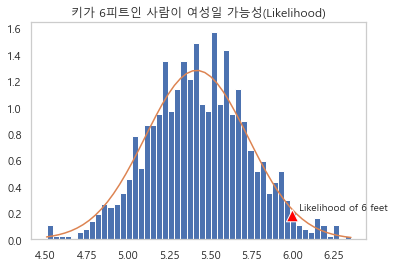

In [11]:
s = np.random.normal(mu_f, sigma_f, 1000)
fig, ax = plt.subplots()
n, bins, ignored = ax.hist(s, 50, density=1) # 50 bins
ax.annotate('  Likelihood of 6 feet', xy=(6., like_f), arrowprops=dict(facecolor='red'))
plt.plot(bins, 1/(sigma_f * np.sqrt(2 * np.pi))* np.exp(- (bins - mu_f)**2 / (2*sigma_f**2)))
plt.title('키가 6피트인 사람이 여성일 가능성(Likelihood)')

In [12]:
import joypy
plt.rcParams['font.family']='Malgun Gothic'
df[['신장','무게','발의크기']]= StandardScaler().fit_transform(df[['신장', '무게', '발의크기']])
fig, axes = joypy.joyplot(df,column = ['신장', '무게', '발의크기'],
                          by = '성별', ylim = 'own', figsize = (15,4))
plt.title('성별에 따른 신장, 몸무게, 발의크기 분포 비교도', fontsize = 18);

ImportError: cannot import name '_subplots' from 'pandas.plotting._matplotlib.tools' (C:\Users\NFSI291\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py)

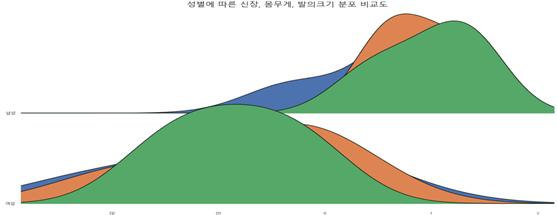

In [13]:
Image(filename='../image/gnb/joyplot.jpg', width=width, height=height)

## Gaussian Naive Bayes

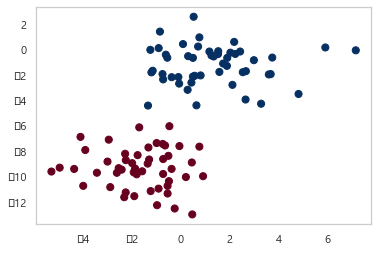

In [13]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

In [14]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [15]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(5000, 2)
ynew = model.predict(Xnew)

의사결정경계선(decision boundary)

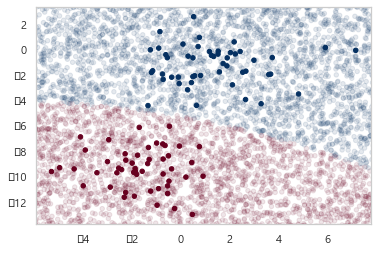

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

의사결정경계선이 곡선으로 나타남

In [18]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Multinomial Naive Bayes

### Example: Classifying Text

- text classification, where the features are related to word counts or frequencies within the documents to be classified.
- The sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

In [19]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [20]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [21]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer (discussed in Feature Engineering), and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [23]:
model.fit(train.data, train.target) 
labels = model.predict(test.data)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data:

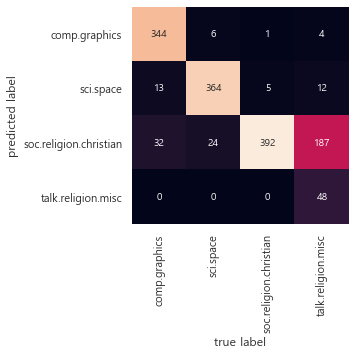

In [24]:
from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(test.target, labels) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=train.target_names, yticklabels=train.target_names) 
plt.xlabel('true label') 
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity. This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for any string, using the predict() method of this pipeline. Here's a quick utility function that will return the prediction for a single string:

In [25]:
def predict_category(s, train=train, model=model): 
    pred = model.predict([s]) 
    return train.target_names[pred[0]]

Let's try it out:

In [26]:
predict_category('sending a payload to the ISS')

predict_category('discussing islam vs atheism')

predict_category('determining the screen resolution')

'sci.space'

'soc.religion.christian'

'comp.graphics'

## 소비자행태 데이터 읽고 훈련시험 데이터 준비

In [27]:
X = pd.read_pickle('../data/X.pkl') # 특성변수만 반영
y = pd.read_pickle('../data/y.pkl')
X.shape, y.shape
X.head()

((3997, 21), (3997,))

,tv4,tv9,drama7,지역_경기인천,지역_부산울산경남,drama3,지역_대구경북,drama15,tv15,drama9,...,연령,인터넷평일,직업_무직기타,모바일주말,모바일평일,drama8,인터넷주말,성별_여,성별_남,drama4
0,0.579234,2.30963,-1.205273,0,0,-0.396918,0,-0.089837,-0.067259,3.407174,...,-1.808444,-1.533759,0,0.900657,1.451424,-0.371179,1.443933,0,1,-1.637911
1,0.579234,-0.43297,-1.205273,0,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-1.808444,-0.804841,0,-0.729510,-0.863126,-0.371179,-0.371716,0,1,0.435808
2,0.579234,2.30963,-1.205273,0,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-1.808444,0.652994,0,1.222392,0.525604,-0.371179,0.082196,0,1,0.435808
3,-1.699504,2.30963,0.782134,0,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-1.808444,0.139761,0,-0.338293,-0.400216,-0.371179,0.379376,0,1,0.435808
4,0.579234,2.30963,-1.205273,0,0,-0.396918,0,-0.089837,-0.067259,-0.293498,...,-1.808444,-1.533759,0,1.222392,1.451424,-0.371179,0.082196,0,1,0.435808


In [28]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)
X_train.shape, X_test.shape
y_train.shape, y_test.shape

((3197, 21), (800, 21))

((3197,), (800,))

## 가우시안 나이브 베이지안((Gaussian naive Bayesian)

In [29]:
from sklearn.naive_bayes import GaussianNB
np.random.seed(1357)

In [30]:
kf = KFold(n_splits=5)
model = GaussianNB()
params = {'var_smoothing': [1e-9, 1e-8,1e-7, 1e-6, 1e-5]}
grid = GridSearchCV(model, param_grid=params, cv=kf, scoring = 'recall_macro')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='recall_macro')

분류임계값 0.5 이상 총 소비자는 340 명


<Figure size 1080x216 with 0 Axes>

(array([196., 260., 335., 400., 460., 514., 547., 605., 675., 800.]),
 array([8.96497409e-202, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <BarContainer object of 10 artists>)

Text(0.5, 0, '분류임계값')

Text(0, 0.5, '부적합업체 예측 누적 수')

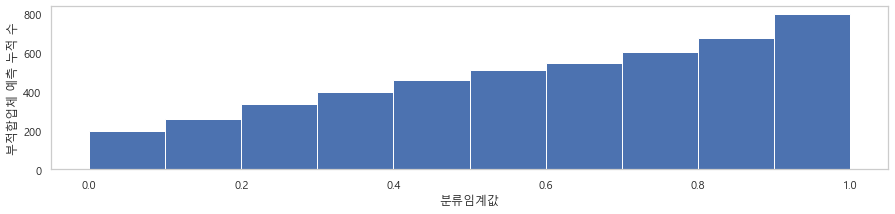

In [31]:
y_predict = grid.predict(X_test); y_proba = grid.predict_proba(X_test)
cut_off = 0.5
print(f'분류임계값 {cut_off} 이상 총 소비자는 {sum((y_proba[:, 1] >= cut_off)*1)} 명')
plt.figure(figsize=(15, 3)); plt.hist(y_proba[:, 1], cumulative=True)
plt.xlabel('분류임계값'); plt.ylabel('부적합업체 예측 누적 수')

In [32]:
data = pd.DataFrame(y_proba, columns =['비구매확률', '구매확률']).round(2)
data['분류'] = y_predict
data.head()

,비구매확률,구매확률,분류
0,0.01,0.99,1
1,0.58,0.42,0
2,0.21,0.79,1
3,0.99,0.01,0
4,0.69,0.31,0


(array([196.,  64.,  75.,  65.,  60.,  54.,  33.,  58.,  70., 125.]),
 array([8.96497409e-202, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <BarContainer object of 10 artists>)

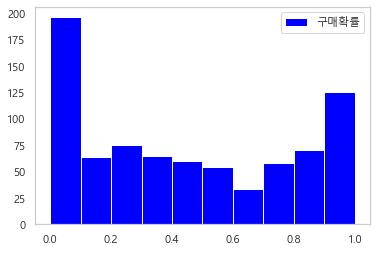

(array([125.,  70.,  58.,  33.,  54.,  60.,  65.,  75.,  64., 196.]),
 array([6.3020557e-43, 1.0000000e-01, 2.0000000e-01, 3.0000000e-01,
        4.0000000e-01, 5.0000000e-01, 6.0000000e-01, 7.0000000e-01,
        8.0000000e-01, 9.0000000e-01, 1.0000000e+00]),
 <BarContainer object of 10 artists>)

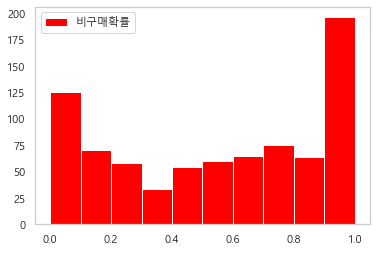

In [33]:
plt.hist(y_proba[:, 1], color ='blue', label='구매확률'); plt.legend(); plt.show()
plt.hist(y_proba[:, 0], color ='red', label='비구매확률'); plt.legend()

In [34]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67       522
           1       0.43      0.53      0.48       278

    accuracy                           0.59       800
   macro avg       0.57      0.58      0.57       800
weighted avg       0.62      0.59      0.60       800



In [35]:
grid.best_estimator_.score(X_test, y_test)
grid.score(X_test, y_test).round(2)
results = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results.sort_values('rank_test_score')

0.595

0.58

,params,mean_test_score,rank_test_score
1,{'var_smoothing': 1e-08},0.612646,1
3,{'var_smoothing': 1e-06},0.612468,2
4,{'var_smoothing': 1e-05},0.612242,3
2,{'var_smoothing': 1e-07},0.611976,4
0,{'var_smoothing': 1e-09},0.609553,5


In [36]:
from sklearn.metrics import roc_auc_score, average_precision_score
auc = roc_auc_score(y_test, y_proba[:,1])
ap = average_precision_score(y_test, y_proba[:,1])
print(f'AUROC :{round(auc * 100, 2)}, AP Mean :{round(ap * 100, 2)}')

AUROC :61.85, AP Mean :48.55


In [37]:
dump(model, '../output/gnb.joblib')

['../output/gnb.joblib']

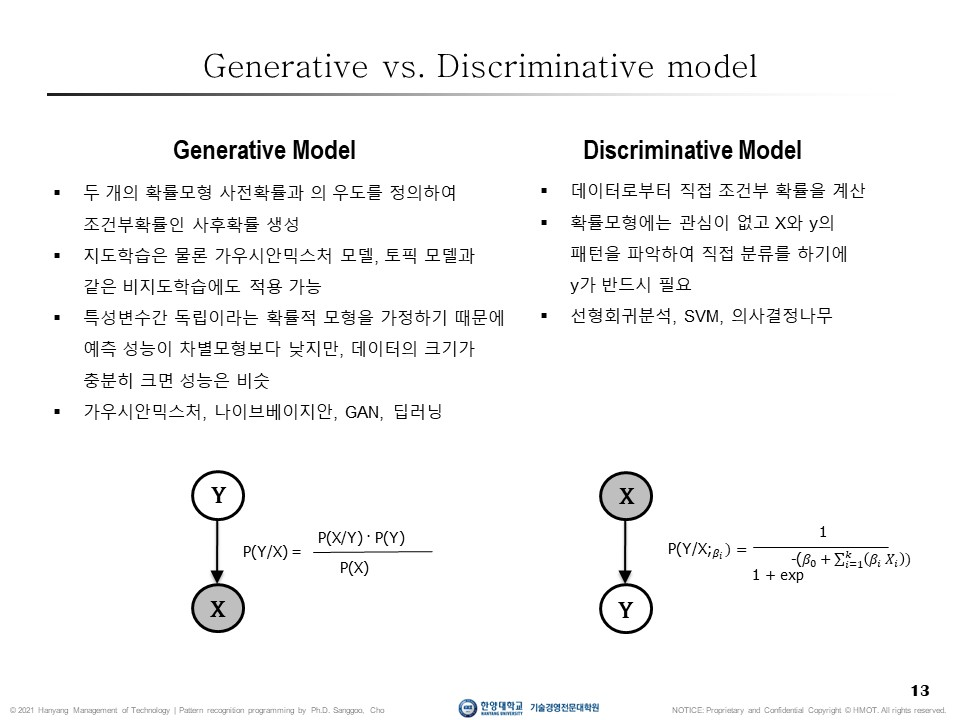

In [38]:
Image(filename='../image/gnb/슬라이드13.jpg', width=width, height=height)

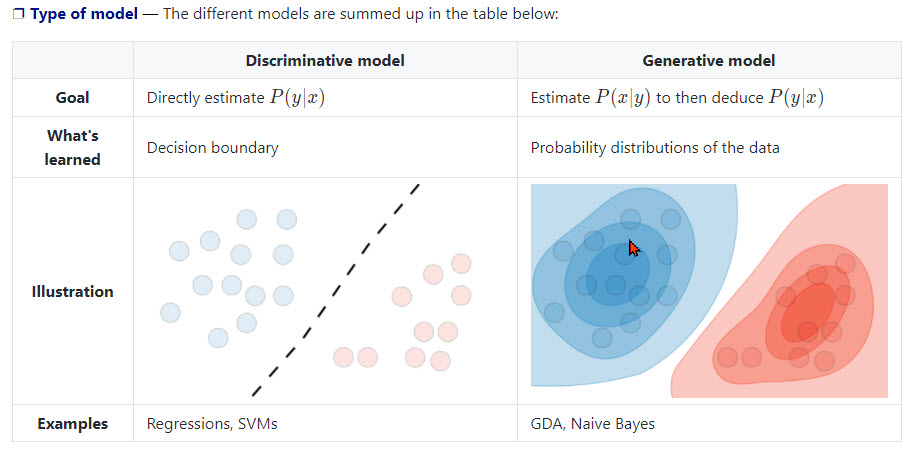

In [39]:
Image(filename='../image/gnb/generative model.jpg', width=width, height=height)

https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning

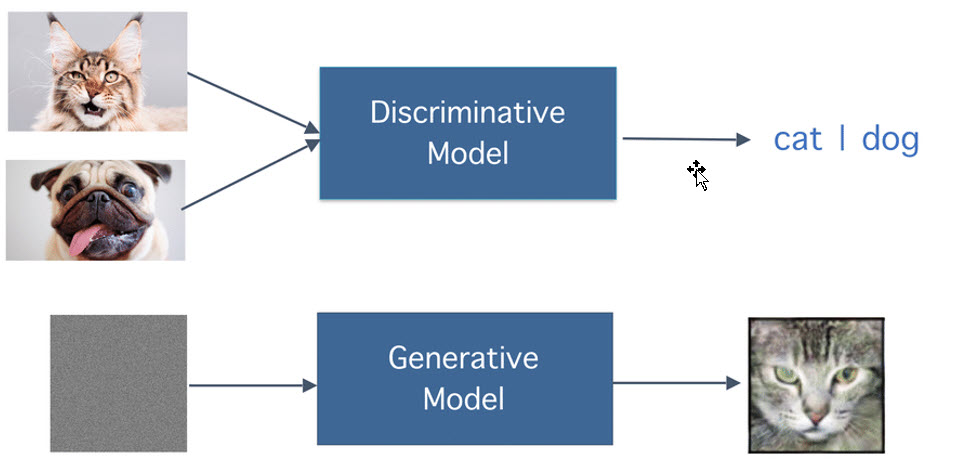

In [40]:
Image(filename='../image/gnb/cat_dog.jpg', width=width, height=height)

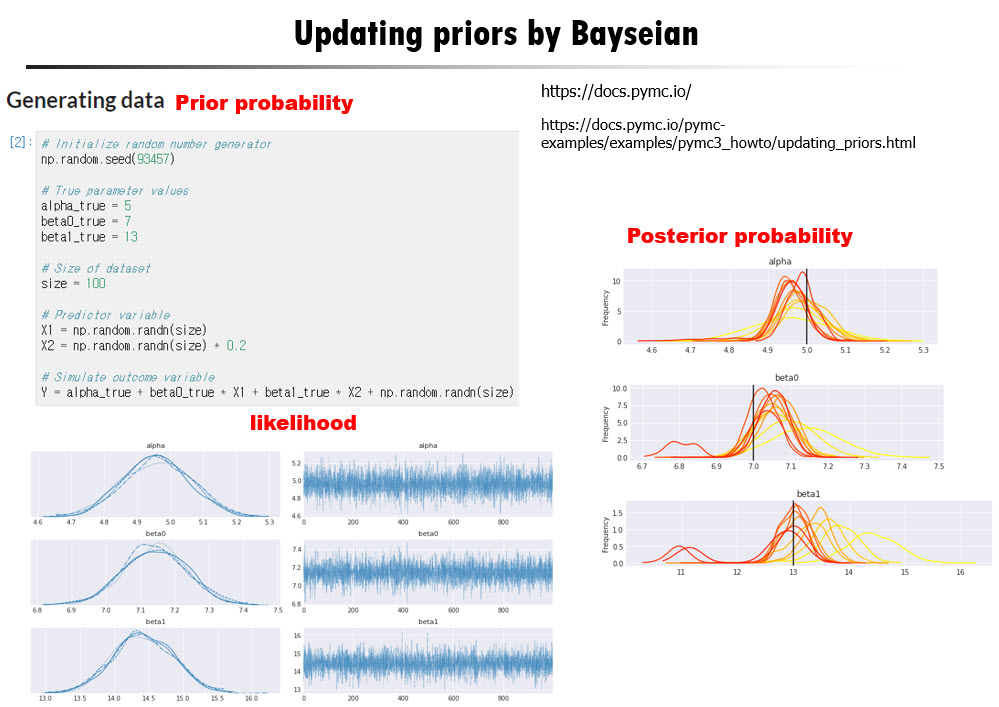

In [41]:
Image(filename='../image/gnb/pymc3_update beliefs.jpg', width=width, height=height)

# END